# Introduction

Last tested version: <img src="https://img.shields.io/badge/Atoti-v0.9.9-blue">

Run this notebook to create an analytical application for the SBM charge - based of the Equity Delta Example. The input data will be stored in-memory and Atoti will perform the computation "on-the-fly" based on user query. You can filter, drill down and explore your data and the SBM metrics.

<img src=https://data.atoti.io/notebooks/sbm/img/app-preview.gif width = 70%>

## About SBM

You will find below how the SBM logic can be described in python and injected into Atoti. We'll narrow down the use case to Equity Delta charge for simplicity. The other aggregation chains can be added in a similar manner.

Sensitivity-based mathod is one of the parametric market risk methodologies. It can be used to compute a VaR-like metric from sensitivities using pre-calibrated risk weights and correlations, through a sequence of nested variance covariance formulae. Due to its multiple benefits (see reference [2]), the method is widely used both internally by orgazations to manage market risk, as well as by Regulators for capital requirements purposes (FRTB) as well as margining (SIMM). 

The notebook assumes that the reader is familiar with the sensitivity-based method and terminology.

## What to expect

In this notebook, we'll read the required sensitivities and calculation parameters and create a chain of measures aggregating data:

sensitivities by trade -> weighted sensitivities by risk factor -> charges by bucket -> equity delta margin


## Input data

Input data is sourced in a CRIF-like format - see [3].

## References 

- [1]: Consolidated Basel Framework Chapter MAR21: https://www.bis.org/basel_framework/chapter/MAR/21.htm?inforce=20220101. 
- [2]: ISDA SIMM(TM): From Principles to Model Specification: https://www.isda.org/a/vAiDE/simm-from-principles-to-model-specification-4-mar-2016-v4-public.pdf
- [3]: ISDA Risk Data Standard: https://www.isda.org/a/owEDE/risk-data-standards-v1-36-public.pdf

# Input data files

These are the csv-files that we need to illustrate the Equity Delta aggregation:

- "bigger_data.csv" - sensitivities in a CRIF-like format
- "eq_delta_gamma.csv" - cross-bucket correlations, set for each pair of buckets
- "eq_delta_rho.csv" - risk factor correlations, set per bucket, i.e. all pairs of risk factors in a given bucket have the same correlation
- "eq_delta_rw.csv" - risk weights, set per bucket and per risk factor type (stored in Label2 crif field)

The example data files are stored in s3. 

<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=sbm" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Atoti table" /></a></div>

In [1]:
import atoti as tt
import pandas as pd
from atoti.agg._vector import vector

Let's start by launching Atoti cube and UI:

In [2]:
session = tt.Session.start(tt.SessionConfig(java_options=["-Xmx12G"]))

session.link

http://localhost:64823

# Sensitivities table

In [3]:
risks_table = session.read_csv(
    "s3://data.atoti.io/notebooks/sbm/bigger_data.csv",
    keys=["TradeID", "PortfolioID", "RiskType", "Qualifier", "Label2"],
    table_name="Risks",
    default_values={"Bucket": 0},
)

In [4]:
# So far we have loaded data only into the risks_table
risks_table.head()

,,,,,AmountUSD,Bucket
TradeID,RiskType,Qualifier,Label2,PortfolioID,,
0,Risk_Equity,Wilmar International,REPO,Bigger_Portfolio,-10332.09,1
9,Risk_Equity,Abbott Laboratories,SPOT,Bigger_Portfolio,220534.64,5
kqagrquwuy,Risk_Equity,Issuer_536,SPOT,Bigger_Portfolio,36972.79766,2
19,Risk_Equity,Merck & Co.,SPOT,Bigger_Portfolio,-271193.07,5
34,Risk_Equity,General Motors,SPOT,Bigger_Portfolio,-712227.16,7


In [5]:
cube = session.create_cube(risks_table)
h, l, m = cube.hierarchies, cube.levels, cube.measures

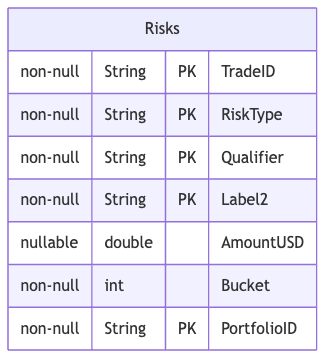

In [6]:
session.tables.schema

Create the numerical column `Bucket` as a hierarchy.

In [7]:
h["Bucket"] = [risks_table["Bucket"]]

At this point, a cube has been created, and we can start browsing the sensitivities:

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
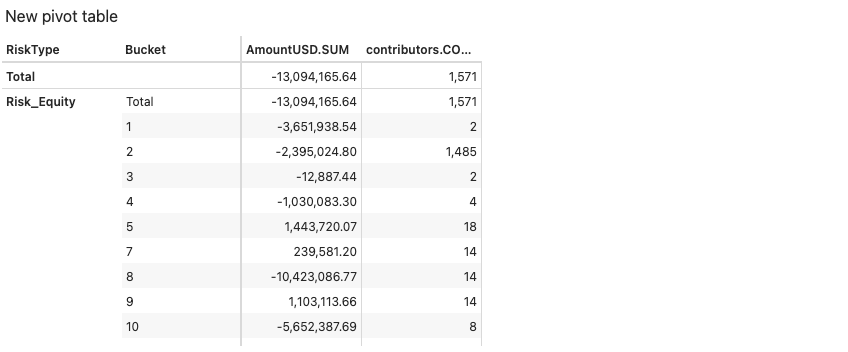

In [8]:
session.widget

In [9]:
# Let's create a first measure - to count distinct Qualifiers
m["Distinct Qualifiers Count"] = tt.agg.count_distinct(risks_table["Qualifier"])

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
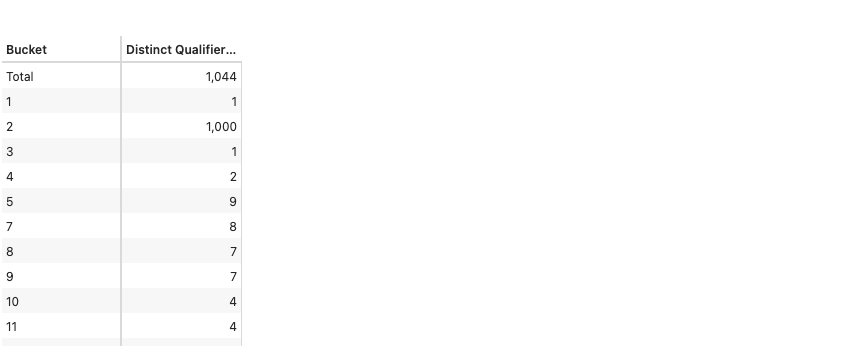

In [10]:
session.widget

# Risk weights table

In [11]:
# the risk weights table is created from a csv:
eq_delta_risk_weights_table = session.read_csv(
    "s3://data.atoti.io/notebooks/sbm/parameters/eq_delta_rw.csv",
    keys=["Bucket", "Label2"],
    table_name="RiskWeights",
)

# risks table is joined with the risk weights table
risks_table.join(eq_delta_risk_weights_table)

In [12]:
eq_delta_risk_weights_table.head(5)

,,RW
Bucket,Label2,
9,SPOT,0.7
8,REPO,0.005
10,SPOT,0.5
13,SPOT,0.25
7,REPO,0.004


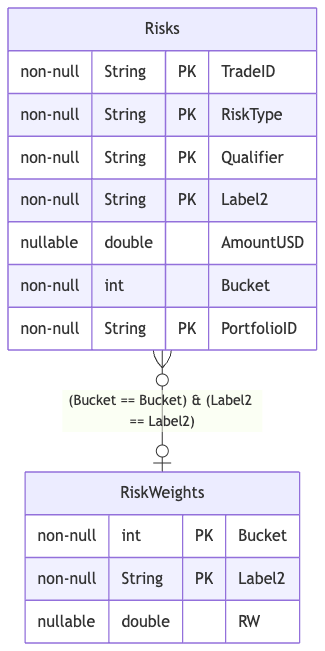

In [13]:
session.tables.schema

We can create measures for the numerical columns in the referenced tables such as `RiskWeights` and `RiskFactorCorrelations`.

In [14]:
m["RW.VALUE"] = tt.agg.single_value(eq_delta_risk_weights_table["RW"])
m["RW.VALUE"] = tt.agg.single_value(eq_delta_risk_weights_table["RW"])
# Let's put it into a folder and format as percentages:
m["RW.VALUE"].folder = "Parameters"
m["RW.VALUE"].formatter = "DOUBLE[#%]"

The risk weights are now available in the cube as a measure.
The measure is defined for Bucket and Label2 - these hierarchies need to be present into the view.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
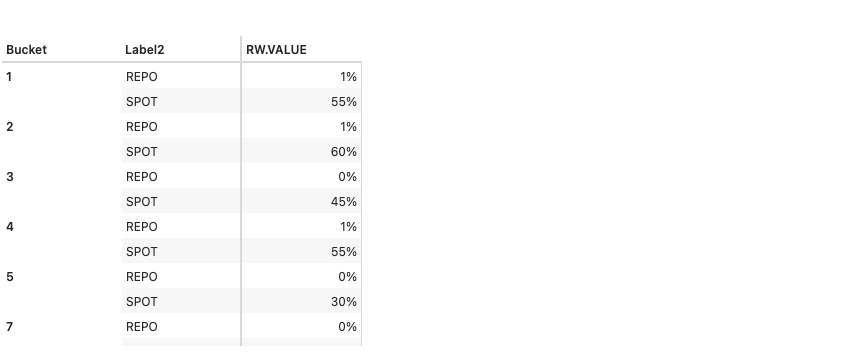

In [15]:
session.widget

# Weighted sensitivities

In this section, we'll create a measure to compute weighted sensitivities defined in
[MAR21.4](https://www.bis.org/basel_framework/chapter/MAR/21.htm?inforce=20220101#paragraph_MAR_21_20220101_21_4):

$$WS_k=RW_k \cdot s_k$$

As the risk weights are defined for each Bucket and Label2, this is the level where sensitivities need to be multiplied by the risk weight.


In [16]:
# The input sensitivities are multplied by the risk weight for each Bucket and Label2,
# and then summed up to obtain weighted sensitivities:
m["WS"] = tt.agg.sum(
    m["AmountUSD.SUM"] * m["RW.VALUE"],
    scope=tt.OriginScope({l["Bucket"], l["Label2"]}),
)

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
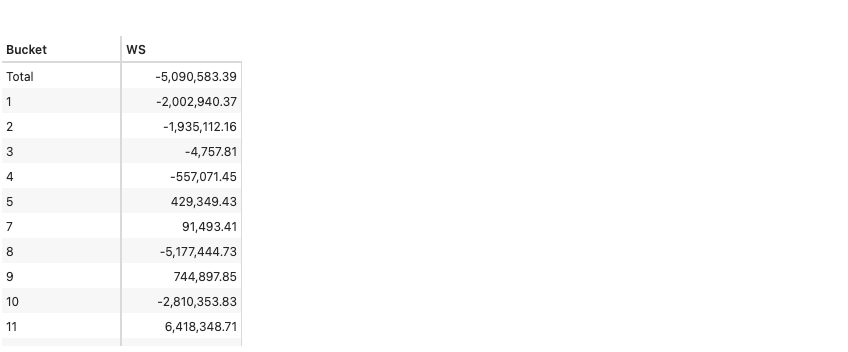

In [17]:
session.widget

# Bucket-level aggregation

The weighted sensitivities by risk factor are rolled up into charges by bucket ("bucket-level charges"), using a variance-covariance-type of formula that can be found in the [MAR21.4](https://www.bis.org/basel_framework/chapter/MAR/21.htm?inforce=20220101#paragraph_MAR_21_20220101_21_4):

$$K_{b} =\sqrt{max \left( 0, \sum _{k\in b} WS_{k}^{2} +\sum _{k\in b}\sum
  _{l\in b, l\neq k}\rho_{kl}\cdot WS_k \cdot WS_l\right)}$$
  
In this section we'll create measures visualizing bucket-level charges. 

We will be leveraging the fact, that some of the risk factor pairs are correlated with the same correlation parameter, and provide a more computationally efficient calculation. 

## Risk factor correlations

The parameter $\rho_{kl}$ denotes correlation between two risk factors $k$ and $l$ in a pair of risk factors. The rules defining the equity delta correlations are set in [MAR21.78](https://www.bis.org/basel_framework/chapter/MAR/21.htm?inforce=20220101#paragraph_MAR_21_20220101_21_78).

The rules can be summarised for each pair of risk factors as follows:

- Case 1: same name, different type: a single value -> 0.999
- Case 2: different name, same type: a single value depending on bucket, for example, 0.15
- Case 3: different name, different type: value depending on risk factor multiplier by 0.999, for example, 0.15 x 0.999

Stylized example:


| risk factors | name1-spot | name1-repo | name2-spot | name2-repo |
|------------|-------------|-------------|-------------|-------------|
| name1-spot | 1 |  |  |  |
| name1-repo | same_name_diff_type | 1 |  |  |
| name2-spot | rho_by_name | rho_by_name x type_multiplier | 1 |  |
| name2-repo | rho_by_name x type_multiplier | rho_by_name x type_multiplier | same_name_diff_type | 1 |

In [18]:
# Equity delta risk factor is defined as a combination of fields - "Qualifier" and "Label2", i.e. equity name and risk factor type.
# Creating variables:
same_risk_factor = 1.0
same_name_diff_type = 0.999
diff_type_multiplier = 0.999

In [19]:
# Creating a table holding correlations defined per bucket ([MAR21.78](2)):
eq_delta_rho = session.read_csv(
    "s3://data.atoti.io/notebooks/sbm/parameters/eq_delta_rho.csv",
    keys=["Bucket"],
    table_name="RiskFactorCorrelations",
)
risks_table.join(eq_delta_rho)
eq_delta_rho.head(5)

,names_correlation
Bucket,
8,0.25
3,0.15
6,0.25
9,0.075
12,0.8


In [20]:
m["names_correlation.VALUE"] = tt.agg.single_value(eq_delta_rho["names_correlation"])
m["names_correlation.VALUE"] = tt.agg.single_value(eq_delta_rho["names_correlation"])
# Let's put it into a folder and format as percentages:
m["names_correlation.VALUE"].folder = "Parameters"
m["names_correlation.VALUE"].formatter = "DOUBLE[0.00]"

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
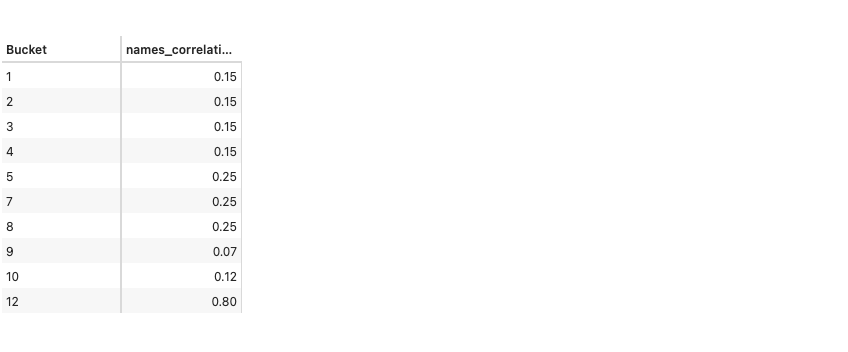

In [21]:
session.widget

Since many of the risk factor pairs share the same correlation value, it is possible to optimize the variance-covariance aggregation. The efficiency of this calculation is critical when the data cardinality along the risk factor is high.

We decompose the formula into the three components:
1. contribution of pairs with both risk factors being spot - same correlation $\rho_{names}$ set per bucket,
2. contribution of pairs with both risk factors being repo - same correlation $\rho_{names}$ set per bucket,
3. contribution of pairs where one risk factor is spot, another one is repo - same correlation $\rho_{names} \cdot 0.999$. We'd need to account that for some of the pairs where one risk factor is spot, one is repo some the equity names will match and need to be correlated at 0.999


Let's start with the pairs where both risk factors are either spot or repo - cases 1. and 2. above. Since for any $k$ and $l$ the correlation $\rho_{kl}$ will be equal to correlation defined per bucket $\rho_{names}$, their contribution can be rewritten:

$$ \sum_k WS_k^2 +  \sum_k \sum_{l \neq k} \rho_{kl} WS_k WS_l = \\ \sum_k WS_k^2 + \rho_{names} \cdot \left(\left( \sum_k WS_k \right)^2 - \sum_k WS_k^2  \right) = \\ (1-\rho_{names}) \cdot \sum_k WS_k^2 + \rho_{names} \cdot \left( \sum_k WS_k \right)^2 \tag{reduced formula} $$

In [22]:
# This measure will display sum of WS_k squared by risk factor (Qualifier + Label2):
m["sum squares"] = tt.agg.square_sum(
    m["WS"], scope=tt.OriginScope({l["Qualifier"], l["Label2"]})
)

In [23]:
reduced_formula = (1 - m["names_correlation.VALUE"]) * m["sum squares"] + m[
    "names_correlation.VALUE"
] * m["WS"] ** 2

# Total contribution of:
# - pairs having only spot risk factors,
# - pairs having only repo risk factors,
# is the sum of the reduced formula by Label2 members.

m["spot&repo pairs contribution"] = tt.agg.sum(
    reduced_formula, scope=tt.OriginScope({l["Label2"]})
)

The contribution of the risk factors where one risk factor belongs to "SPOT" and the other belongs to "REPO" - case 3 above - can be rewritten:

$$ \sum_k WS_k^2 +  \sum_k \sum_{l \neq k} \rho_{kl} WS_k WS_l = \\ \vec{WS_{repo}^T} \cdot J_{n_{repo}, n_{spot}} \cdot \vec{WS_{spot}} \cdot \rho_{names} \cdot 0.999 + 0.999 \cdot (1 - \rho_{names}) \sum_{n\in names}{WS_n^{repo} \cdot WS_n^{spot}} $$

where:
- J - is a matrix of ones,
- first term in the above formula performs aggregation of all sensitivities, as if they all are correlated at $\rho_{names}$,
- the second term is to correct the first term and to account for the fact that risk factors, where spot and repo risk factors have the same equity name, must be correlated at 0.999.


**First term**

The measure `sum WS_repo |J| WS_spot` will display $\vec{WS_{repo}^T} \cdot J_{n_{repo}, n_{spot}} \cdot \vec{WS_{spot}} $.

In [24]:
# filtering for repo and spot risk factors:
m["WS_spot"] = tt.filter(m["WS"], l["Label2"] == "SPOT")
m["WS_repo"] = tt.filter(m["WS"], l["Label2"] == "REPO")

# Collect WS of the spot risk factors in a vector and show against every qualifier in a bucket:
m["weights_vector"] = vector(
    m["WS_spot"], scope=tt.OriginScope({l["Bucket"], l["Qualifier"]})
)

m["spot vector"] = tt.total(m["weights_vector"], h["Qualifier"])

# cross product of weighted sensitivities for the names, having both spot and repo sensitivities:
# Multiply vector WS of the spot risk factors by WS of each repo risk factor sum them up
repo_scalar_x_spot_vector = m["WS_repo"] * m["spot vector"]
m["sum WS_repo |J| WS_spot"] = tt.agg.sum(
    tt.array.sum(repo_scalar_x_spot_vector),
    scope=tt.OriginScope({l["Bucket"], l["Qualifier"]}),
)

**Second term**

The measure `sum WS repo and spot` will display $\sum_{n\in names}{WS_n^{repo} \cdot WS_n^{spot}}$

In [25]:
m["WS_spot_parent"] = tt.agg.sum(m["WS_spot"], scope=tt.OriginScope({l["Label2"]}))
m["WS_repo_parent"] = tt.agg.sum(m["WS_repo"], scope=tt.OriginScope({l["Label2"]}))


m["sum WS repo and spot"] = tt.agg.sum(
    m["WS_spot_parent"] * m["WS_repo_parent"],
    scope=tt.OriginScope({l["Qualifier"]}),
)

**Combined result cross spot & repo pairs**

In [26]:
# final contribution of the pairs where one risk factor is spot, one is repo
m["cross repo spot contribution"] = (
    m["names_correlation.VALUE"] * m["sum WS_repo |J| WS_spot"] * 0.999
    + 0.999 * (1 - m["names_correlation.VALUE"]) * m["sum WS repo and spot"]
)

**Total Kb**

In [27]:
m["Kb"] = tt.where(
    l["Bucket"] == 11,
    tt.agg.sum(
        tt.math.abs(m["WS"]), scope=tt.OriginScope({l["Qualifier"], l["Label2"]})
    ),
    tt.math.sqrt(
        tt.math.max(
            0, m["spot&repo pairs contribution"] + 2 * m["cross repo spot contribution"]
        )
    ),
)

In [28]:
cube.query(m["Kb"], levels=[l["Bucket"]])

,Kb
Bucket,
1,"2,002,940.32"
2,"1,247,249.60"
3,"4,757.80"
4,"758,465.49"
5,"456,861.06"
7,"932,682.89"
8,"3,937,788.92"
9,"2,234,809.96"
10,"1,819,315.90"


# Cross-bucket aggregation

## Bucket correlations

In [29]:
eq_delta_buckets_correlations = session.read_csv(
    "s3://data.atoti.io/notebooks/sbm/parameters/eq_delta_gamma.csv",
    keys=["Bucket", "Other Bucket"],
    table_name="eq_delta_corr_outer",
)
risks_table.join(eq_delta_buckets_correlations)

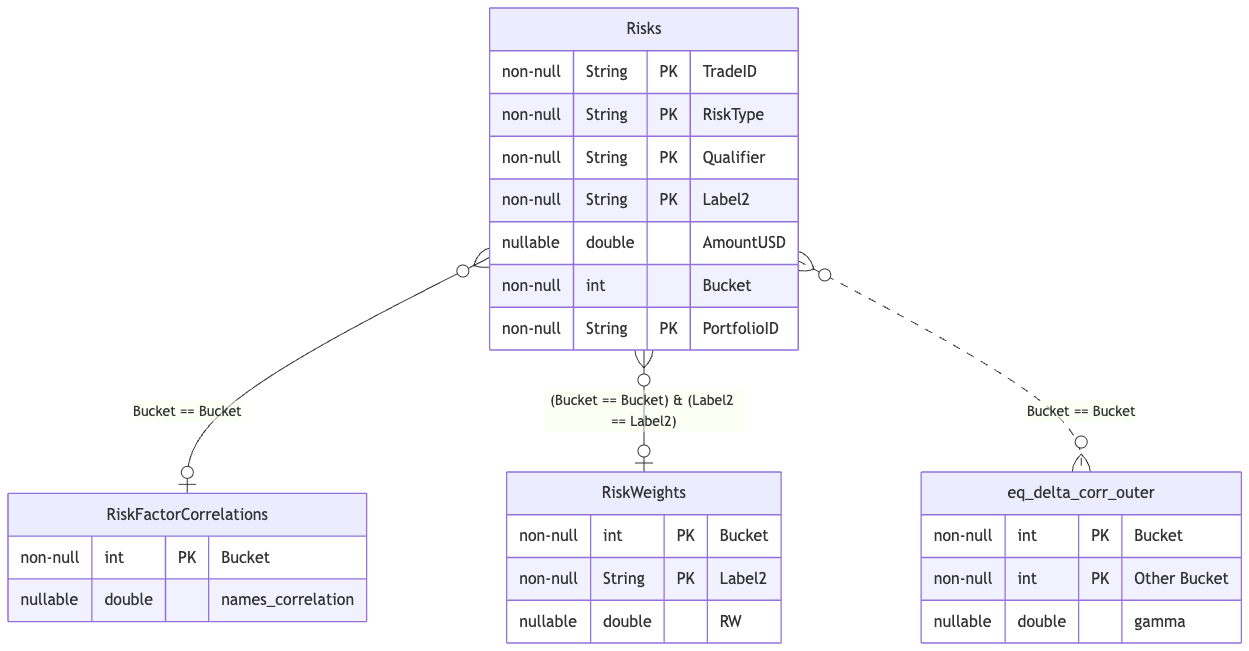

In [30]:
session.tables.schema

Again, let's create the measure for gamma from the referenced table `eq_delta_corr_outer table`.

In [31]:
m["gamma.VALUE"] = tt.agg.single_value(eq_delta_buckets_correlations["gamma"])

We can show/hide the grand total column and row from the following pivot table by doing a right-click on the column headers, and accessing the corresponding function.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
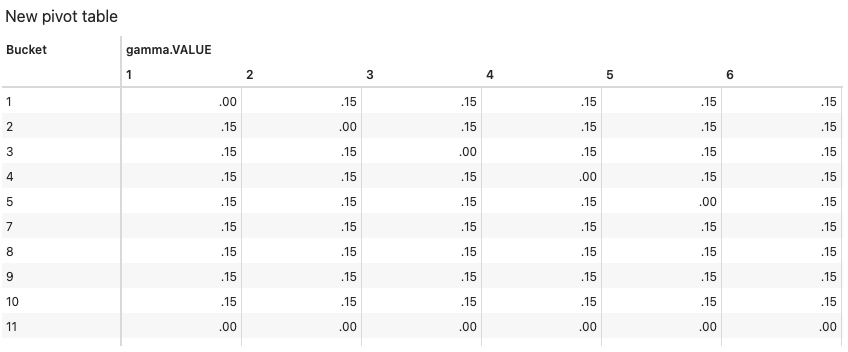

In [32]:
session.widget

## Aggregating across buckets

In [33]:
# 21.4(5)(a):
m["WSb"] = m["WS"]
m["WSc"] = tt.at(m["WS"], (l["Bucket"] == l["Other Bucket"]))
m["sum Kb2 + sum sum WSb WSc gamma"] = tt.agg.square_sum(
    m["Kb"], scope=tt.OriginScope({l["Bucket"]})
) + tt.agg.sum(
    m["WSb"] * m["WSc"] * m["gamma.VALUE"],
    scope=tt.OriginScope({l["Bucket"], l["Other Bucket"]}),
)

# 21.4(5)(b):
m["Sb"] = tt.math.max(tt.math.min(m["WS"], m["Kb"]), -1.0 * m["Kb"])
m["Sc"] = tt.at(m["Sb"], (l["Bucket"] == l["Other Bucket"]))
m["sum Kb2 + sum sum Sb Sc gamma"] = tt.agg.square_sum(
    m["Kb"], scope=tt.OriginScope({l["Bucket"]})
) + tt.agg.sum(
    m["Sb"] * m["Sc"] * m["gamma.VALUE"],
    scope=tt.OriginScope({l["Bucket"], l["Other Bucket"]}),
)

m["Risk Charge"] = tt.where(
    m["sum Kb2 + sum sum WSb WSc gamma"] > 0,
    tt.math.sqrt(m["sum Kb2 + sum sum WSb WSc gamma"]),
    tt.math.sqrt(m["sum Kb2 + sum sum Sb Sc gamma"]),
)

In [34]:
cube.query(m["Risk Charge"])

,Risk Charge
0,"9,357,880.51"


# Enriching the data model

The current data model can be displayed using `cube.schema` command.

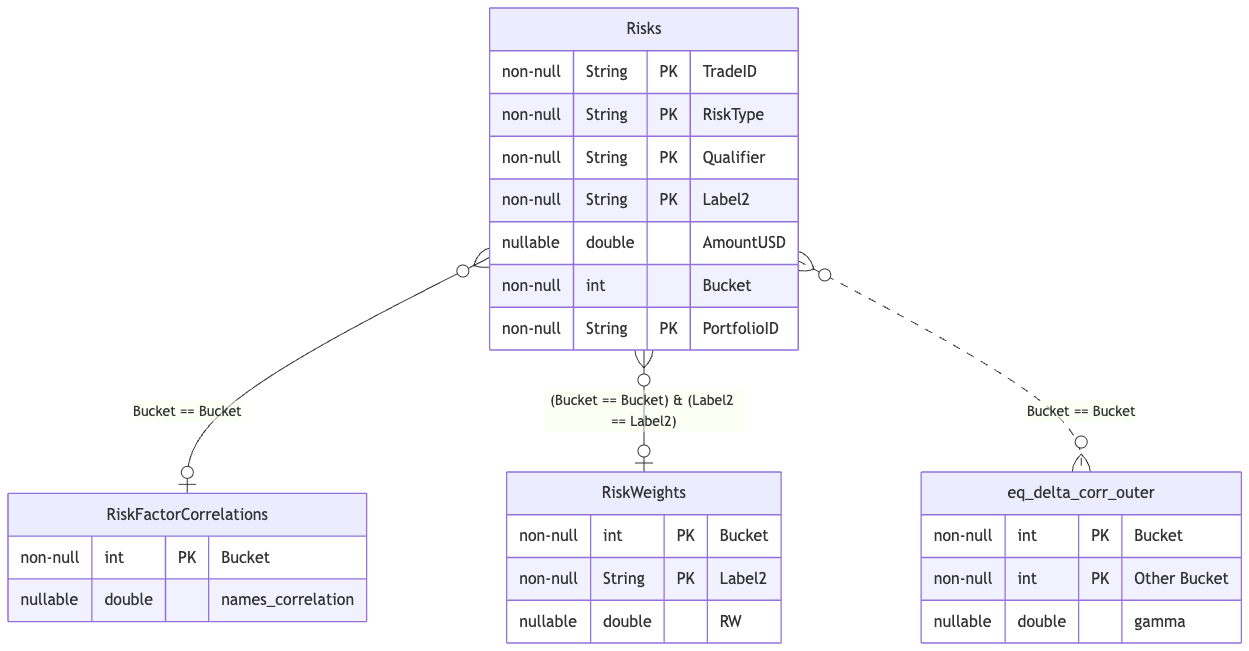

In [35]:
session.tables.schema

Let's group trades into books, desks, business units:

In [36]:
# Trade attributes table will hold trade identifiers and trade attributes, in our example, book
trade_attributes = session.read_csv(
    "s3://data.atoti.io/notebooks/sbm/trade_attributes.csv",
    keys=["TradeID"],
    table_name="Trade Attributes",
)

# Trade desks table will hold multi-level org structure
trading_desks = session.read_csv(
    "s3://data.atoti.io/notebooks/sbm/trading_desk.csv",
    keys=["Book"],
    table_name="Trading Desk",
)

# Linking together the data
risks_table.join(trade_attributes)
trade_attributes.join(trading_desks)

In [37]:
# Setting up a multi-level hierarchy book -> desk -> sub-unit -> unit
h["Trading Book Hierarchy"] = {
    "Business Unit": l["business_unit"],
    "Sub Business Unit": l["sub_business_unit"],
    "Trading Desk": l["trading_desk"],
    "BookID": l["Book"],
}

The new schema is as follows:

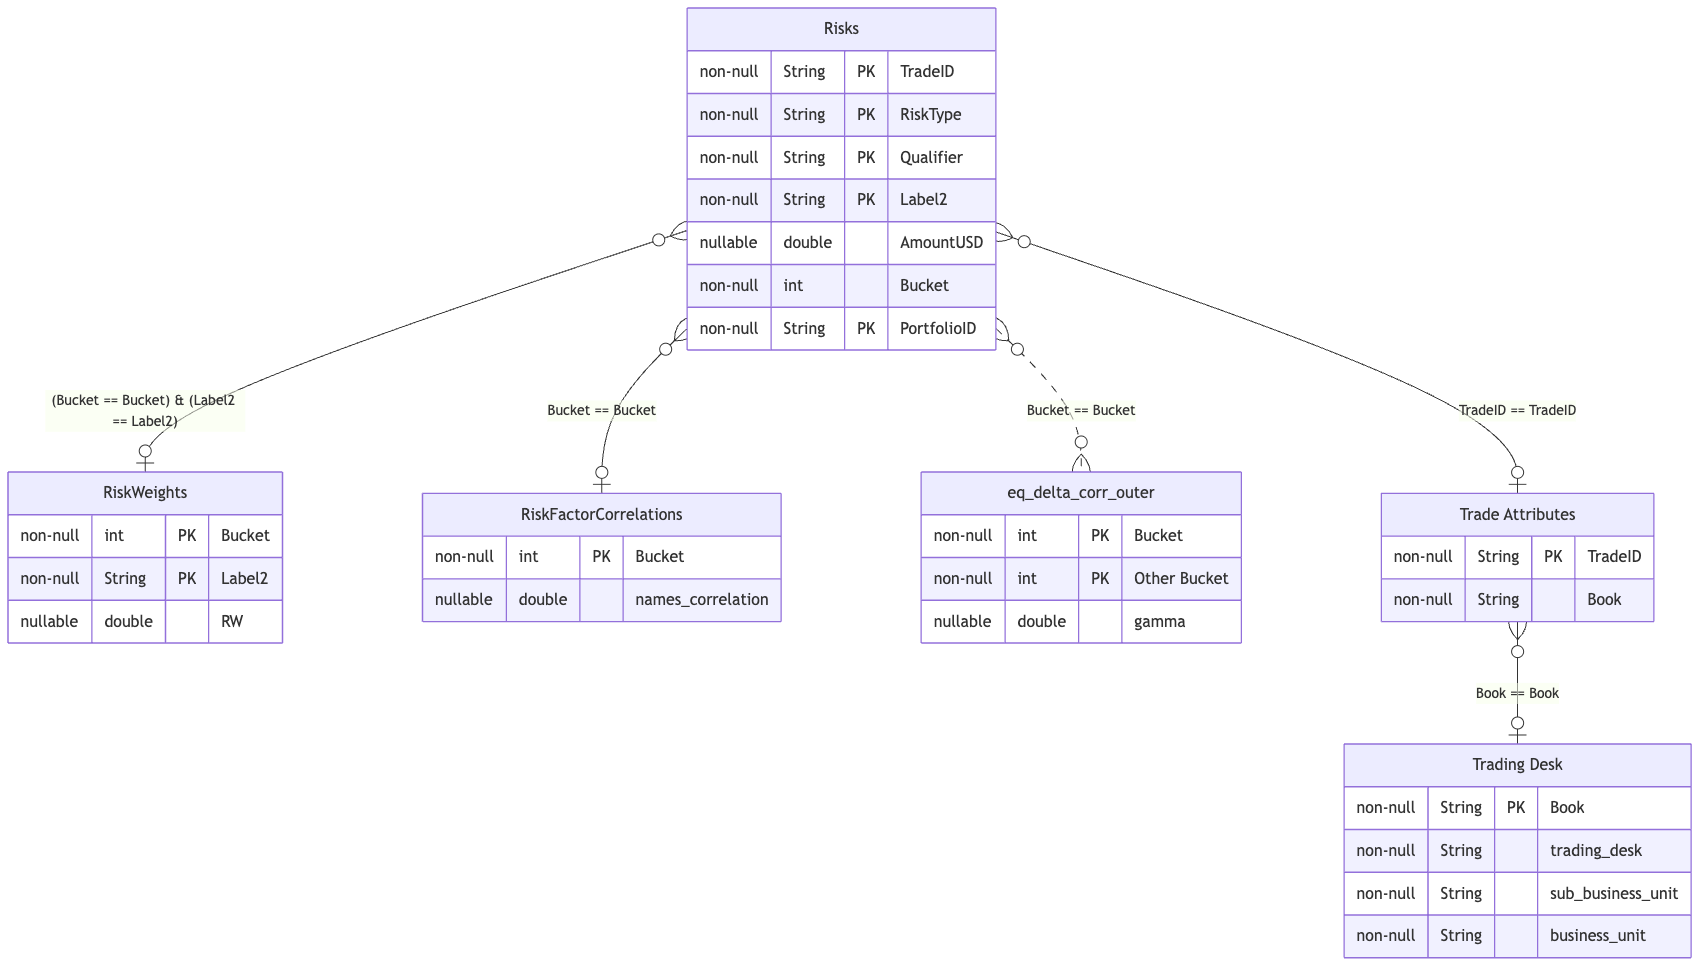

In [38]:
session.tables.schema

Now we can compute SBM interactively for various desks and books and drill down to sensitivities by trade and risk factor.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
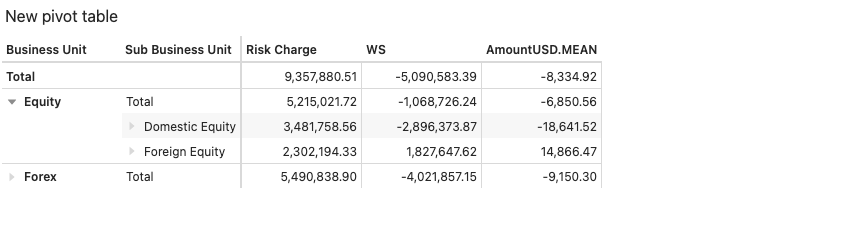

In [39]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
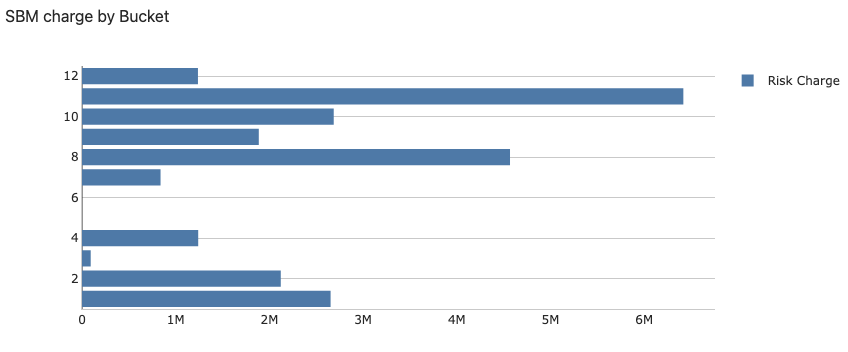

In [40]:
session.widget

<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=sbm" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Atoti table" /></a></div>